In [208]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, classification_report, accuracy_score


## Objetivo del proyecto
- Objetivo: Pronosticar tasa de cancelación de clientes
- Tipo de modelo: Clasificación
- Característica objetivo: la columna `'EndDate'` es igual a `'No'`.
- Métrica principal: AUC-ROC.
- Métrica adicional: exactitud.
- Criterios de evaluación:
- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

In [39]:
# Importing datasets
contract_df = pd.read_csv('datasets/contract.csv')
internet_df = pd.read_csv('datasets/internet.csv')
personal_df = pd.read_csv('datasets/personal.csv')
phone_df = pd.read_csv('datasets/phone.csv')

## Preprocessing

In [40]:
# # Functions
def category_check(df,columns):
    '''When data frame and columns provided, the function
    will return the value counts of each column'''
    for col in columns:
        print()
        print(df[col].value_counts(), end='\n\n')

#### Contract dataset

In [41]:

contract_df.head(4)
contract_df.info()
category_check(contract_df,['Type','PaymentMethod'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64


PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64



- Se observan columnas con formato PascalCase a excepción de customerID, 
- Las columnas BeginDate y EndDate pueden ser modificadas al formato timestamp,
- Lo columna Type puede ser cambiada al tipo Category al ser pocos elementos categóricos (Ocupará menos memoria)
- PaperlessBilling puede ser una categoría no relevante para el estudio
- PaymentMethod puede ser cambiada al tipo Category al ser pocos elementos categóricos (Ocupará menos memoria)
- MonthlyCharges se encuentra correctamente asignado
- TotalCharges debe ser cambiado a tipo Float

In [42]:
# Renombrado customerID
contract_df.rename(columns={'customerID': 'CustomerID'}, inplace=True)

In [43]:
# Buscando duplicados
contract_df.duplicated().sum()
# No fueron encontrados valores duplicados

0

In [44]:
# Buscando valores nulos
nan_values = contract_df[contract_df.isna().any(axis=1)]
nan_values
# No fueron encontrados valores_nulos

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [45]:
# Las columnas BeginDate y EndDate pueden ser modificadas al formato timestamp,
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format= '%Y-%m-%d')

In [46]:
# Cambiando tipos de Columna a category
contract_df['Type'] = contract_df['Type'].astype('category')
contract_df['PaymentMethod'] = contract_df['PaymentMethod'].astype('category')

In [47]:
# Cambiando Total Charges a float y configurando valores no numéricos a NA

valores_no_numericos = pd.to_numeric(contract_df['TotalCharges'], errors='coerce').isna()
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce')

# PENDIENTE PARA CONSIDERAR ENCONTRAR TOTAL CHARGES

#### Internet dataset

In [48]:
internet_df.head(4)
internet_df.info()

category_check(internet_df, internet_df.columns[1:] )
#No hay elementos fuera de los rangos No, Yes.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64


OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64


OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64


DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64


TechSupport
No     3473
Yes    2044
Name: count, dtype: int64


StreamingTV
No     2810
Yes    2707
Name: 

In [49]:
# Buscando duplicados
internet_df.duplicated().sum()
#No fueron encontrados valores duplicados
#Columna customerID será transformada a PascalCase

0

In [50]:
# Renombrado customerID
internet_df.rename(columns={'customerID': 'CustomerID'}, inplace=True)

#### Personal dataset

In [51]:
personal_df.sample(4)
personal_df.info()
category_check(personal_df,personal_df.columns[1:])
personal_df.duplicated().sum()
# - Los elementos no cuentan con valores duplicados ni ausentes, muestra coherencia en los datos.
# - Podrían categorizarse las columnas Gender, Partner y Dependents


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

gender
Male      3555
Female    3488
Name: count, dtype: int64


SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64


Partner
No     3641
Yes    3402
Name: count, dtype: int64


Dependents
No     4933
Yes    2110
Name: count, dtype: int64



0

In [52]:
personal_df.rename(columns={'gender': 'Gender'}, inplace=True)
personal_df.rename(columns={'customerID': 'CustomerID'}, inplace=True)
# - Gender, CustomerID no están aplicando CamelCase, se procede a cambiarlos al formato.

In [53]:
#### Phone dataset
phone_df.sample(4)
phone_df.info()
category_check(phone_df,phone_df.columns[1:])
phone_df.duplicated().sum()

# - Los elementos no cuentan con valores duplicados ni ausentes, muestra coherencia en los datos.
# - Podrían categorizarse la columna MultipleLines
# - Gender, CustomerID no estan aplicando CamelCase, se procede a cambiarlos al formato.

phone_df.rename(columns={'customerID': 'CustomerID'}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64



### Funciones para el análisis de caracteristicas

In [54]:
def plot(df, cols, grid):
    '''Esta funcion crera un grid de todos los elementos deseados a analizar
    en un histograma, solo sera necesario esecificar el df de origen, el nombre de
    las columnas y el grid a utilizar ex. grid=(2,2)'''
    fig, axes = plt.subplots(grid[0],grid[1], figsize=(15,10))
    axes= axes.flatten()

    for i,col in enumerate(cols):
        axes[i].hist(df[col])
        axes[i].set_title(f'{col} Histogram')

    plt.tight_layout()
    plt.show()

def distribution(df):
    '''Esta funcion devuelve los valores únicos en porcentajes
    solo será necesario especificar el df y se analizará cada columna'''
    stats=[]
    for col in df:
        stats.append([df[col].value_counts(normalize=True)*100])
    return stats

## Análisis de contract

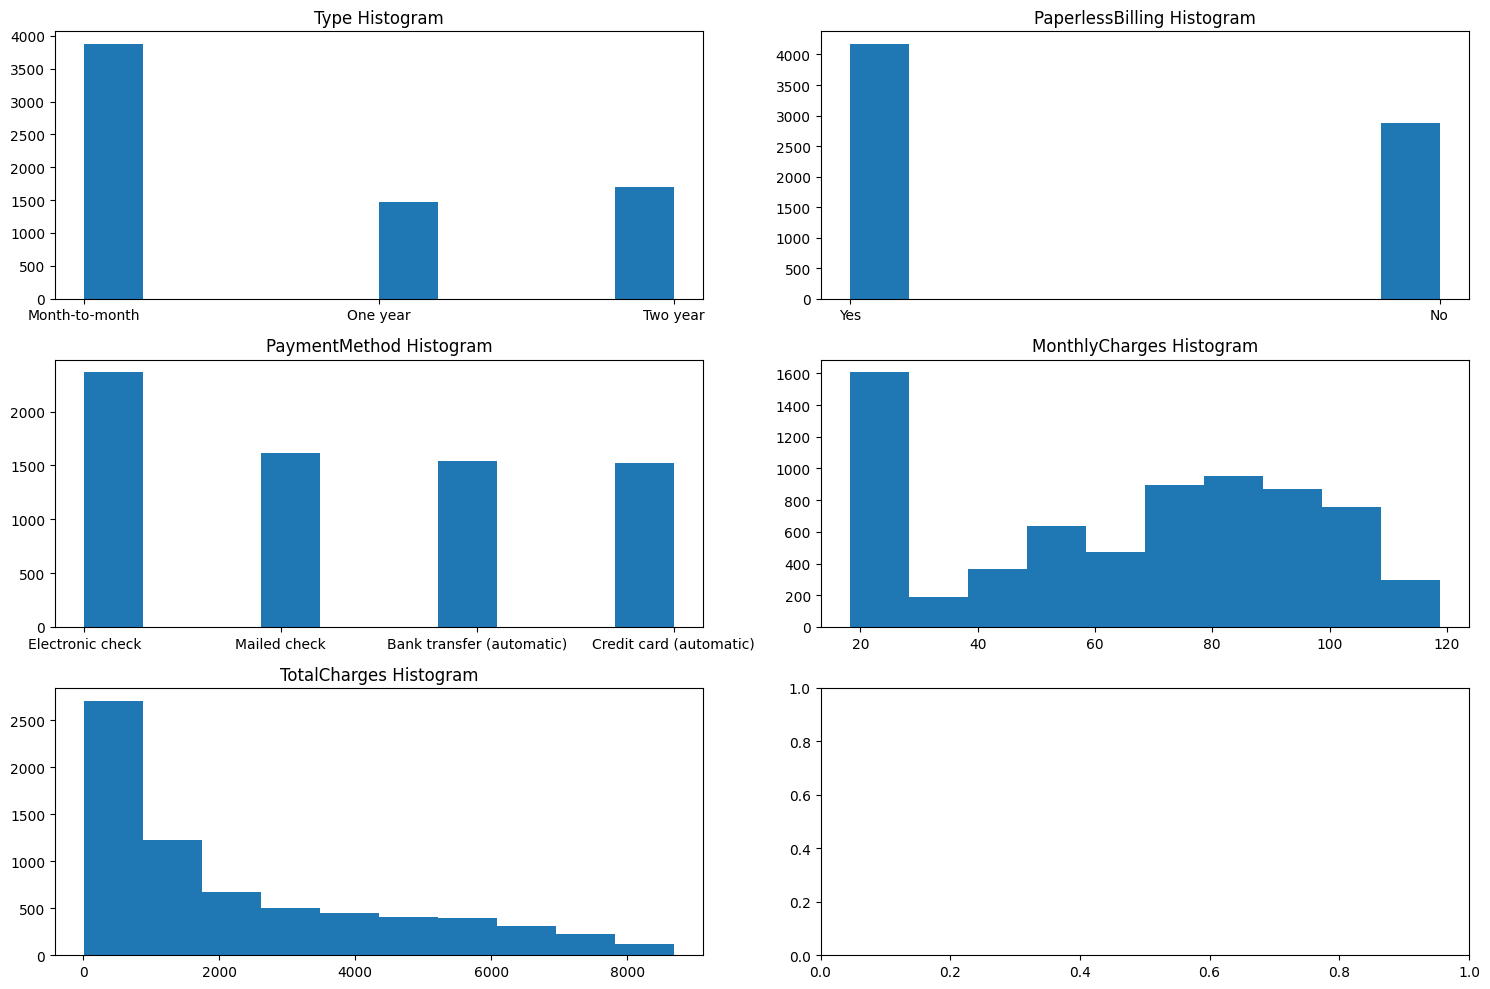

In [55]:
distribution(contract_df.iloc[:,3:-2])
plot(contract_df, contract_df.iloc[:,3:], grid=(3,2))

- Tipo de pago: De acuerdo con el gráfico mostrado la preferencia de los usuarios de Interconnect se inclina
a pagos mensuales como primera opción, seguido de pagos anuales y finalmente pagos cada dos años.
- Pagos impresos: La mayoría de los usuarios aún prefieren sus facturas en formato físico, aunque observamos que 
una gran cantidad de usuarios tienen preferencia al formato digital.
- Método de pago: El método de pago mas recurrido es el de cheque electrónico, seguido de cheque por mail,
transferencia bancaria (automática) y finalmente tarjeta de crédito.

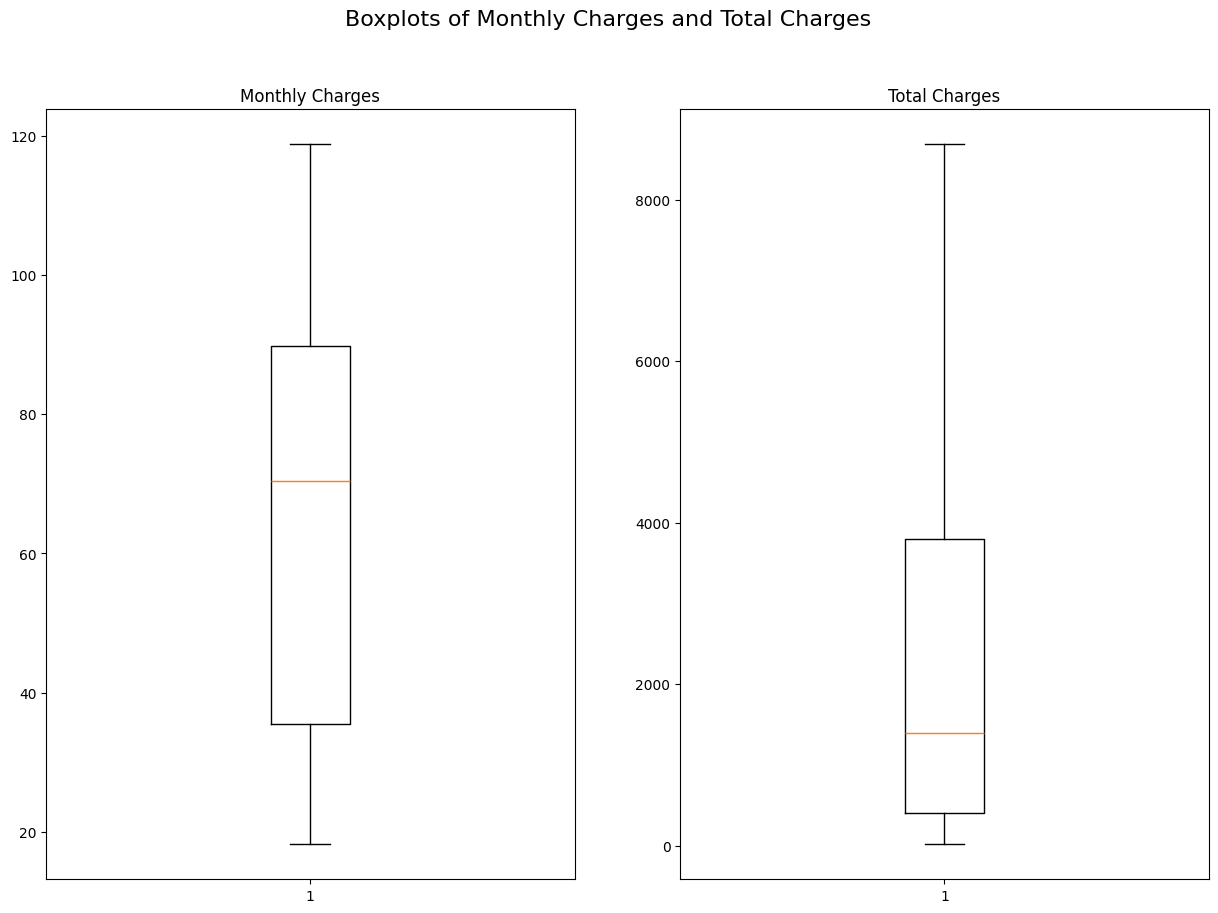

In [80]:
contract_df['MonthlyCharges'].describe()


fig, axes = plt.subplots(1,2, figsize=(15,10))
axes[0].boxplot(contract_df['MonthlyCharges'],showfliers=True)
axes[0].set_title('Monthly Charges')

axes[1].boxplot(contract_df[~contract_df['TotalCharges'].isna()]['TotalCharges'],showfliers=True)
axes[1].set_title('Total Charges')

fig.suptitle('Boxplots of Monthly Charges and Total Charges', fontsize=16)
plt.show()


- Cargo Mensual: Los cargos mensuales tienen una media alrededor de 65 y no presenta valores atípicos,
además, presenta una mínima de 18.25 y una máxima de 118.75 M/N
- Cargos totales: Los cargos totales tienen una media de 2283.30 con una maxima de 8684.80 y una mínima de 18.8,
no se presentan valores atípicos.

## Análisis de internet

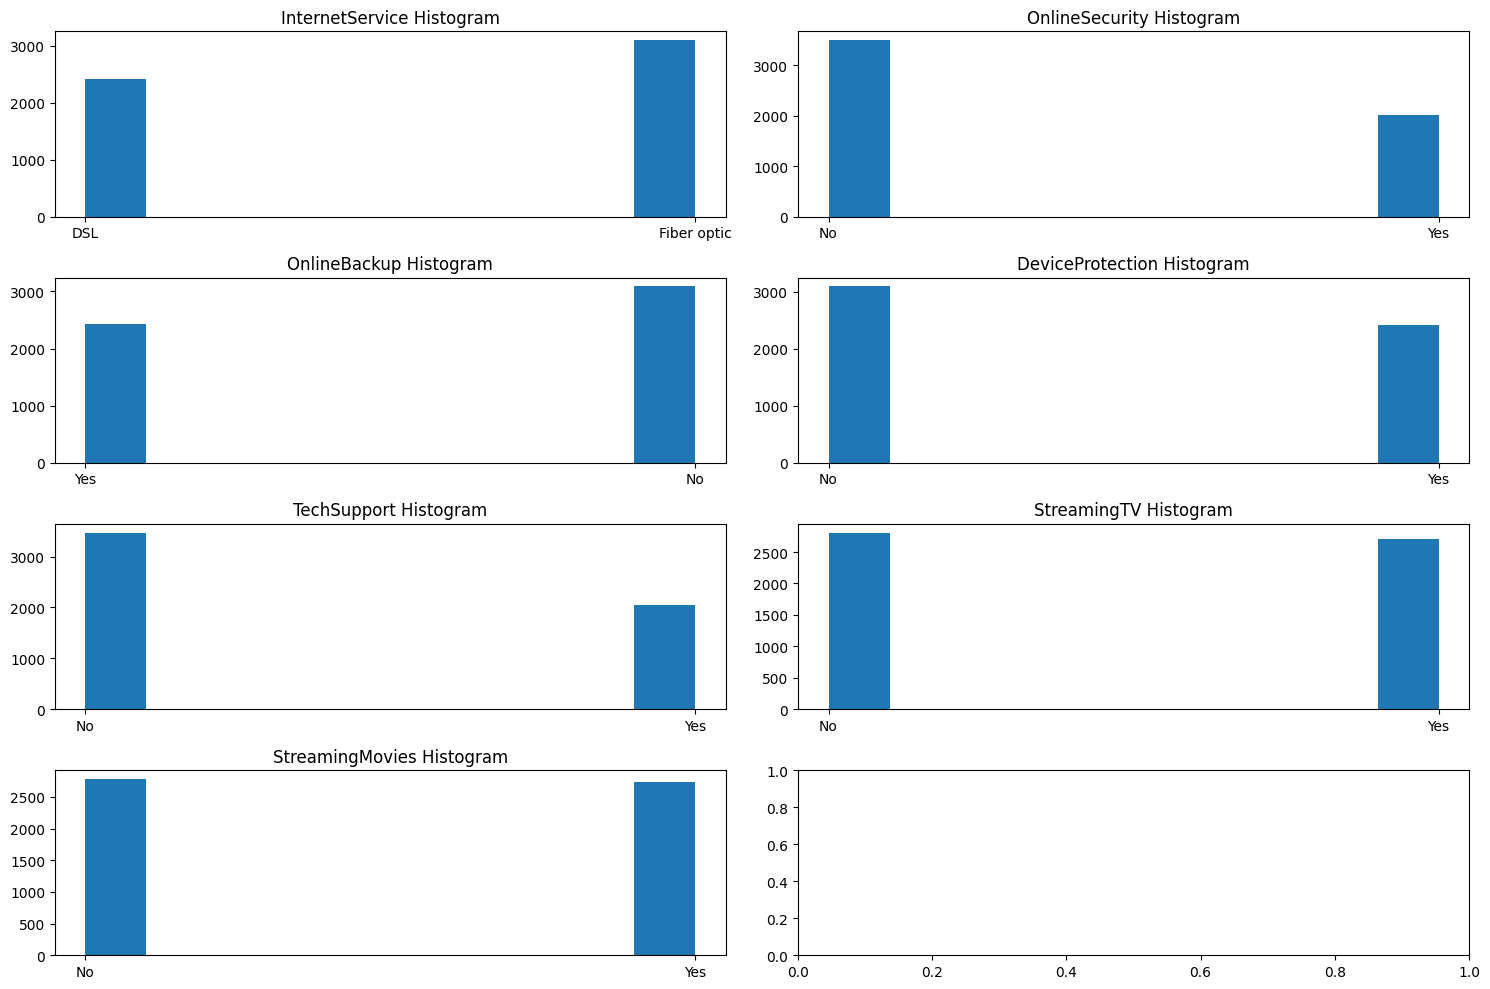

In [20]:
distribution(internet_df.iloc[:,1:])
plot(internet_df, internet_df.iloc[:,1:], grid=(4,2))
#Obtener la distribución de los valores.

- Servicio de internet: La fibra óptica es la infraestructura mas utilizada para el servicio de Interconnect, 
sin embargo, mas de 2000 usuarios (alrededor del 43%) aún cuentan con DSL lo cuál no podría ser la mejor opción con las necesidades actuales.
- Servicio de seguridad online: La mayoría de los usuarios no usan este servicio, solo un 37% lo tiene contratado, esto puede deberse a
a la falta de necesidad por los servicios integrados de seguridad por windows/apple.
- Servicio de respaldo: Un 44% de los usuarios tienen contratado este servicio para respaladar su información
- Servicio de protección de dispositivos: Un 44% de los usuarios hacen uso de esta servicio.
- Servicio de Tech Support: El 63% no utiliza el servicio de soporte técnico
- Streaming TV: Casi la mitad de los usuarios (49%) utilizan el servicio de streaming TV
- StreamingMovies: La mitad de los usuarios utilizan el servicio de streaming TV

## Análisis de personal

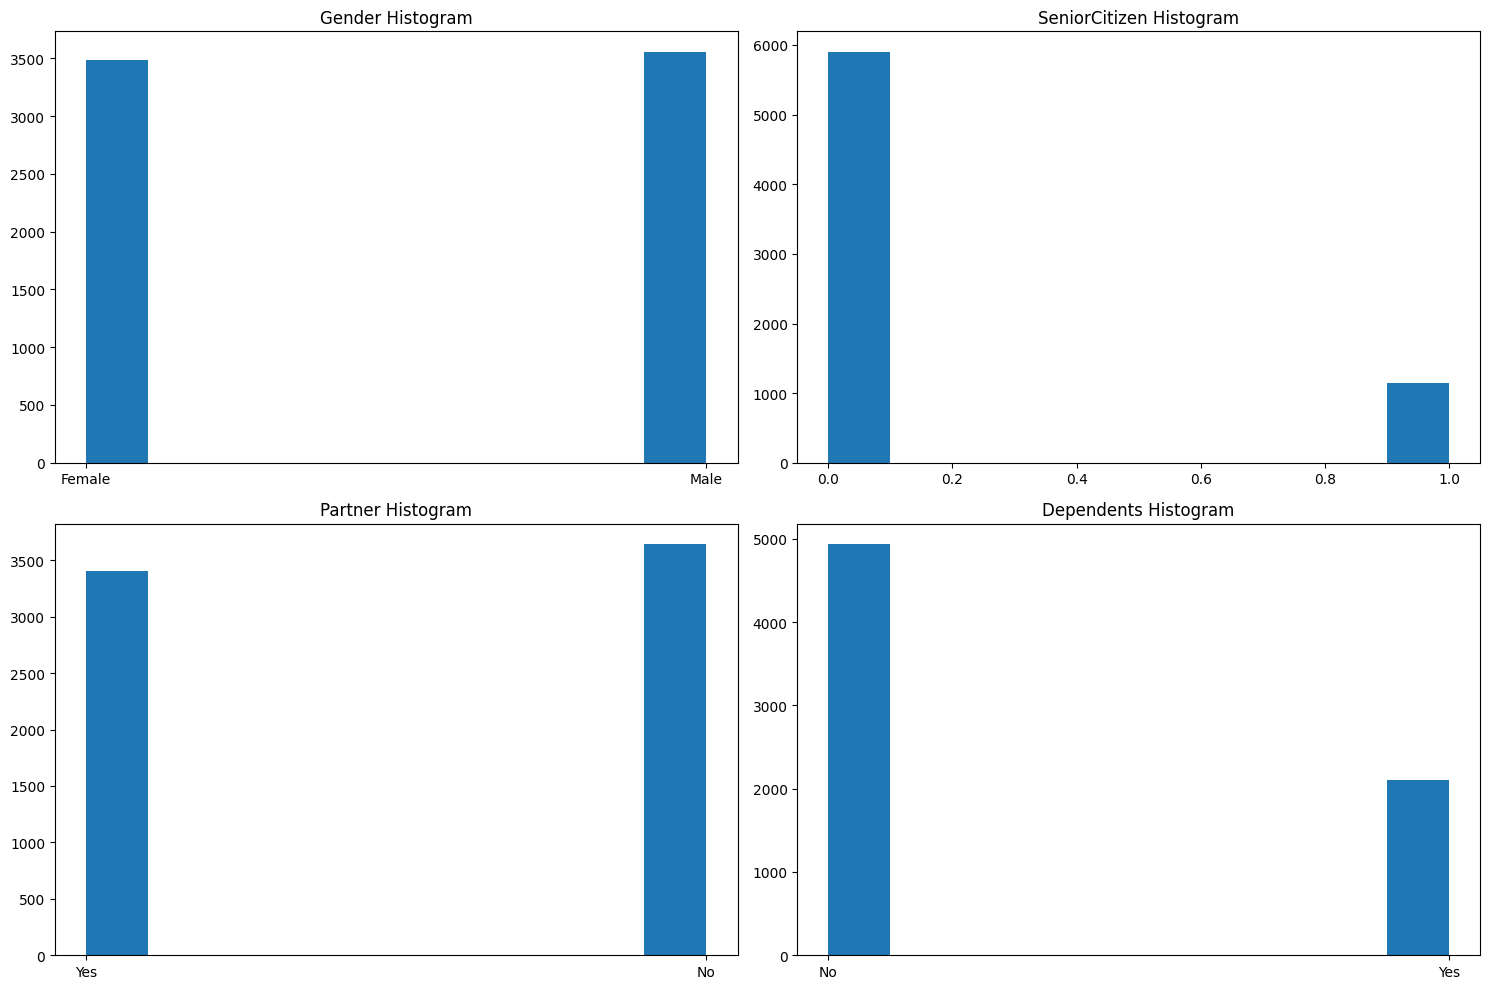

[[Gender
  Male      50.47565
  Female    49.52435
  Name: proportion, dtype: float64],
 [SeniorCitizen
  0    83.785319
  1    16.214681
  Name: proportion, dtype: float64],
 [Partner
  No     51.69672
  Yes    48.30328
  Name: proportion, dtype: float64],
 [Dependents
  No     70.041176
  Yes    29.958824
  Name: proportion, dtype: float64]]

In [21]:
plot(personal_df, personal_df.iloc[:,1:], grid=(2,2))
distribution(personal_df.iloc[:,1:])

- Genero: La distribución de genero es equitativa, 50% para ambos grupos.
- SeniorCitizen: El 83% de usuarios son mayores de 60 años.
- Compañero: El 51% de usuarios tienen una pareja
- Dependientes: Solo el 30% de los usuarios tienen dependientes.

## Análisis de phone

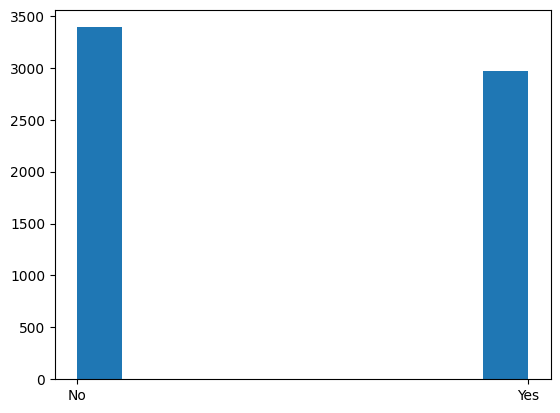

In [22]:
distribution(phone_df.iloc[:-1])
plt.hist(phone_df['MultipleLines'])
plt.show()


- Multiples Lineas: El 53% de los usuarios posen una linea, mientras que el 47% tienen contratadas multiples lineas.

### Union de los conjuntos de datos

In [85]:
merged_df = pd.merge(contract_df, internet_df, how='outer', on='CustomerID')
merged_df = pd.merge(merged_df, personal_df, how='outer', on='CustomerID')
merged_df = pd.merge(merged_df, phone_df, how='outer', on='CustomerID')
merged_df.info()
# merged_df[merged_df.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

- Tenemos valores faltantes al realizar el merge entre desde los datasets internet_df y phone_df, sera necesario imputar
los datos o removerlos.
- Contamos con 7043 datos totales, 2211 cuentan con valores nulos.

In [139]:
training_df = merged_df.dropna()
test_df = merged_df[merged_df.isna().any(axis=1)]


### Funciones para valores categóricos 

In [96]:
from sklearn.preprocessing import LabelEncoder
def label_encoder(df):
    label_mappings ={}
    for col in df:
        le = LabelEncoder()
        df[col]= le.fit_transform(df[col])
        label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    return df, label_mappings

def reverse_label_encoding(df, mappings):
    df_reversed = df.copy()
    for col, mapping in mappings.items():
        reverse_mapping = {v: k for k, v in mapping.items()}
        df_reversed[col] = df_reversed[col].map(reverse_mapping)
    return df_reversed


### Transformando valores categoricos a numéricos

El siguiente apartado busca transformar los valores categoricos a numéricos para poder crear un modelo que nos ayude a rellenar los valores faltantes.

In [110]:
to_encode_df = training_df.select_dtypes(exclude='number').iloc[:,3:]
df_encoded, label_mappings = label_encoder(to_encode_df)
already_numeric_df = training_df.select_dtypes(include='number')


In [113]:
train_df = pd.concat([training_df.iloc[:,0:3],df_encoded], axis=1 )
train_df = pd.concat([train_df,already_numeric_df ], axis=1)

In [118]:
X_data = train_df.iloc[:,3:]

## Imputar valores faltantes

### Metodo 1 

### Metodo 2

###  Metodo 3 Imputación por Linear Regresion

In [246]:
#hacer opcion LinearRegression y LogisticRegression

def imputate(features, objective):
    # lr = LogisticRegression(max_iter=1000)
    lr = LinearRegression()
    X_train, X_val, y_train, y_val,= train_test_split(features,objective, random_state=1212, test_size=0.25)
    lr.fit(X_train,y_train)
    pred = lr.predict(X_val)
    
    compare= pd.DataFrame({'prediction':pred,'real':y_val.values}, index=range(len(pred)))

    
    # val_score = root_mean_squared_error(y_val, pred)
    # print(val_score)

    # acc = accuracy_score(y_val, pred)
    # print(acc)
    
    return compare

In [184]:
X_train = X_data.drop(columns='TotalCharges')
y_train = X_data['TotalCharges']
# test_df




In [187]:
X_train_v2 =  X_data[['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','MultipleLines', 'MonthlyCharges']]

In [195]:
X_train_v3 = X_data[['InternetService','MonthlyCharges']]

In [207]:
# Imputando Total Charges
imputate(X_train_v3,y_train)

NameError: name 'accuracy_score' is not defined

In [216]:
X_train.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Gender', 'Partner', 'Dependents', 'MultipleLines',
       'MonthlyCharges', 'TotalCharges', 'SeniorCitizen'],
      dtype='object')

In [218]:
X_train = X_data.drop(columns=['InternetService','TotalCharges'])
y_train = X_data['InternetService']


In [248]:
x = imputate(X_train,y_train)


In [252]:
x['prediction'] = abs(round(x['prediction']))

In [254]:
x
accuracy_score(x['prediction'],x['real'])

1.0